# An Idea for a Better Adaptive Sampler

## Joe Ryan, Python Agent Team

In [2]:
from IPython.display import HTML as DHTML
import os
os.environ["PATH"] += os.pathsep + '/usr/local/Cellar/graphviz/2.40.1/bin/'

from graphviz import Digraph
from IPython.display import SVG

# function to create those toggle buttons, adapted from something from stackoverflow
def add_toggle_button(desc, *inputs):
    x = ', '.join([str(x) for x in inputs])
    n = str(inputs[0])
    
    code = '''
        <script>
        var others%n = [%x];
        var code_shown%n = true; 
        function code_toggle%n () {
            var selector = "div.input";
            var inputs = $(selector).toArray();
            if (code_shown%n) {
                for (var i in others%n) {
                    var x = others%n[i];
                    $(inputs[x]).hide();
                }
            }
            else {
                for (var i in others%n) {
                    var x = others%n[i];
                    $(inputs[x]).show();
                }
            }

            code_shown%n = !code_shown%n;
        } 
        $( document ).ready(code_toggle%n);
        </script>
        <form action="javascript:code_toggle%n()">
        <input type="submit" value="Toggle on/off the display of the %d code.">
        </form>'''
    
    return code.replace('%d', desc).replace('%n', str(n)).replace('%x', x)

DHTML(add_toggle_button('document setup', 0))

# What is it?

## Trying to model adaptive sampling like a feedback controller to more closely track the sampling target

![https://image.ibb.co/mYDMfz/ezgif_2_509b5d914b.gif](https://image.ibb.co/mYDMfz/ezgif_2_509b5d914b.gif)

# What's the Goal?

## Hopefully get more complete traces out of the spans we already generate under high fan-in and fan-out conditions

### (or get the same number of complete traces for the same number of spans)

# Is it complicated? Does it require tons more agent-level computation?

## No!

## The only extra thing it needs beyond the original is the timestamp when the harvest started

## Will get to agent-level details if we have time - want to talk about it from a system level first.

# What is Fan-In?

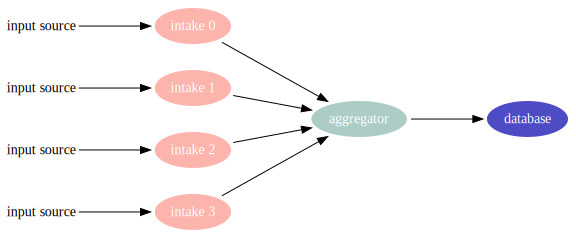

In [3]:
displayed_graph = Digraph()
displayed_graph.attr(rankdir='LR', scale='1', ranksep='1')

in_width = '0.5'
num_nodes = 4

displayed_graph.node('d',
                     'database',
                     style='filled',
                     peripheries='2',
                     penwidth='0',
                     fillcolor='#4d4cc5',
                     fontcolor='#ffffff')

displayed_graph.node('a',
                     'aggregator',
                     style='filled',
                     peripheries='2',
                     penwidth='0',
                     fillcolor='#adccc5',
                     fontcolor='#ffffff')

displayed_graph.edge('a', 'd')

for i in range(num_nodes):
    intake_name = 't' + str(i)
    input_name = 'i' + str(i)
    
    displayed_graph.node(intake_name,
                         'intake ' + str(i),
                         style='filled',
                         peripheries='2',
                         penwidth='0',
                         fillcolor='#fcb4ac',
                         fontcolor='#ffffff')

    displayed_graph.node(input_name,
                         'input source',
                         style='filled',
                         penwidth='0',
                         margin='0',
                         width=in_width,
                         fillcolor='#ffffff',
                         fontcolor='#000000')

    displayed_graph.edge(intake_name, 'a')
    displayed_graph.edge(input_name, intake_name)

display(SVG(displayed_graph.pipe(format='svg')))
DHTML(add_toggle_button('fan-in', 1))

# What is Fan-out?

```python
from newrelic.api.background_task import background_task
from num2words import num2words

@background_task()
def super_duper_important_task():
    for i in range(times):
        i_th = num2words(i, to='ordinal_num')
        msg = 'Hello, for the %s time!' % i_th)
        
        requests.post(
            'https://aggregator.whatever.com:1337/cooldata',
            timeout=1000,
            verify=cert_loc,
            data={'payload': msg})


super_duper_important_task(like_a_freaking_billion_times)
```

# Comparing New to the Original

In [4]:
%run ss/process_real_degredation.py

plot_real_comparison_degradation_results('000000')
plot_real_comparison_degradation_results('2314731')
DHTML(add_toggle_button('comparison', 2))

Figure(axes=[Axis(color='black', label='Average Trace Length', scale=LinearScale(max=260.0, min=0.0)), Axis(co…

Figure(axes=[Axis(color='black', label='Average Trace Length', scale=LinearScale(max=260.0, min=0.0)), Axis(co…

# Comparing at trace-level

In [5]:
from bqplot import LinearScale, OrdinalColorScale, ColorAxis, Axis, Lines, Scatter, Figure
from ipywidgets import HBox, VBox, SelectionSlider, jslink, jsdlink, Layout, IntText, Label
from scipy import signal


x_sc = LinearScale(min=0)
y_sc = LinearScale(min=0)

ax_x = Axis(label='Fan-in', color='black',
             scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Average Difference of sampled=True trace percentages', scale=y_sc, side='left', grid_lines='solid',
             orientation='vertical', color='black', tick_format=".0%")

colors = {
    '4345270': '#1f0537',
    '2155560': '#240d34',
    '4120950': '#2a1b30',
    '2679406': '#2B222E',
    '2066188': '#3f0673',
    '2638951': '#628599',
    '4132727': '#8c45b7',
    '828085':  '#a288c6',
    '2350895': '#b564db',
    '2638956': '#c977ec',
    '2314731': '#de84ff',
}

xdata = range(1, 11)
datasets = {
    '4345270': [0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.004],
    '2155560': [0.000, 0.000, 0.001, 0.002, 0.004, 0.005, 0.006, 0.008, 0.012, 0.021],
    '2679406': [0.000, 0.000, 0.002, 0.004, 0.007, 0.009, 0.012, 0.017, 0.028, 0.042],
    '2066188': [0.000, 0.000, 0.003, 0.008, 0.014, 0.019, 0.026, 0.039, 0.057, 0.074],
    '2638951': [0.000, 0.001, 0.005, 0.012, 0.020, 0.028, 0.040, 0.060, 0.084, 0.105],
    '4132727': [0.000, 0.001, 0.005, 0.012, 0.021, 0.029, 0.042, 0.063, 0.088, 0.109],
    '828085':  [0.000, 0.001, 0.005, 0.014, 0.024, 0.033, 0.048, 0.073, 0.100, 0.123],
    '2350895': [0.000, 0.001, 0.005, 0.014, 0.024, 0.033, 0.048, 0.073, 0.100, 0.124],
    '2638956': [0.000, 0.001, 0.006, 0.015, 0.025, 0.035, 0.052, 0.078, 0.107, 0.130],
    '2314731': [0.000, 0.001, 0.006, 0.015, 0.026, 0.036, 0.052, 0.079, 0.108, 0.133]
}


marks = []
for name in datasets:
    ydata = datasets[name]

    line_mark = Lines(
        x=xdata,
        y=ydata,
        colors = [colors[name]],
        scales={'x': x_sc, 'y': y_sc},
        labels=[name],
        enable_hover=True,
        default_size=12,
        display_legend=True)
    marks.append(line_mark)

fig = Figure(
    marks=marks,
    axes=[ax_x, ax_y],
    legend_location='top-left',
    title='% extra traces gained, proposed AS - current AS')

display(fig)
DHTML(add_toggle_button('trace-level', 3))

Figure(axes=[Axis(color='black', label='Fan-in', scale=LinearScale(min=0.0)), Axis(color='black', label='Avera…